# Basic Demo for D-Wave in Braket: Graph Partitioning

In this tutorial we solve a small instance of a graph partitioning problem using the D-Wave device on Amazon Braket. The derivation for this QUBO problem is nicely explained here: https://github.com/dwave-examples/graph-partitioning.

Disclaimer: The code shown in this example has been taken from D-Wave tutorial availbale online [here](https://github.com/dwave-examples/graph-partitioning), with copyright to D-Wave Systems, Inc., licensed under the Apache License. The purpose of this example is to show how existing code using D-Wave's Ocean tool suite can easily be run on Amazon Braket, with minimal code changes, using the ```BraketDWaveSampler```.

In [1]:
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

In [2]:
import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline
import networkx as nx
from collections import defaultdict
from itertools import combinations
import math
import time
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite

__NOTE__: Please enter your S3 bucket and key below. 

In [3]:
# Please enter the S3 bucket you created during onboarding in the code below
my_bucket = f"amazon-braket-Your-Bucket-Name" # the name of the bucket
my_prefix = "Your-Folder-Name" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [4]:
# session and device
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

Device: Device('name': DW_2000Q_6, 'arn': arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6)


## HELPER FUNCTIONS

In [5]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
    # positions for all nodes
    # pos = nx.spring_layout(graph)

    # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=400)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    #plt.savefig("figures/random_graph.png") # save as png
    plt.show();

In [6]:
# helper function to plot graph
def get_colored_graph(graph, pos, colors):
    """
    plot colored graph for given solution
    """
    
    # positions for all nodes
    # pos = nx.spring_layout(graph)
    
    colorlist = ['#377eb8', '#e41a1c']
    nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')
    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png


## SETTING UP THE GRAPH PARTITIONING PROBLEM

Graph on 50 nodes created with 242 out of 1225.0 possible edges.


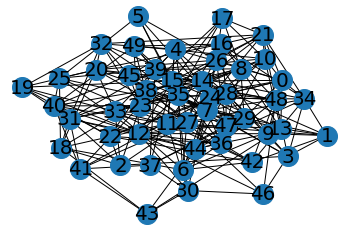

In [7]:
# Copyright 2019 D-Wave Systems, Inc.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# ------- Set tunable parameters -------
num_reads = 1000
gamma = 80

# ------- Set up our graph -------
vertices = 50
G = nx.gnp_random_graph(vertices, 0.2)

print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
                                                                           len(G.edges), 
                                                                           len(G.nodes) * (len(G.nodes)-1) / 2))

# ------- Plot our graph -------
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Fill in Q matrix
for u, v in G.edges:
    Q[(u,u)] += 1
    Q[(v,v)] += 1
    Q[(u,v)] += -2

for i in G.nodes:
    Q[(i,i)] += gamma*(1-len(G.nodes))

for i, j in combinations(G.nodes, 2):
    Q[(i,j)] += 2*gamma

## SOLVING THE PROBLEM ON DWAVE

In [8]:
# ------- Run our QUBO on the QPU -------

# Set chain strength
chain_strength = gamma*len(G.nodes)

# Run the QUBO on Braket
start = time.time()

sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chain_strength, num_reads=num_reads)

# See if the best solution found is feasible, and if so print the number of cut edges.
sample = response.record.sample[0]

# In the case when n is odd, the set may have one more or one fewer nodes
if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
    num_cut_edges = 0
    for u, v in G.edges:
        num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
    print("Valid partition found with", num_cut_edges, "cut edges.")
else:
    print("Invalid partition.")


# print execution time
end = time.time()
print('Code execution time [sec]:', end - start)

Valid partition found with 102 cut edges.
Code execution time [sec]: 76.79747676849365


In [9]:
# print result
sample

array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 0], dtype=int8)

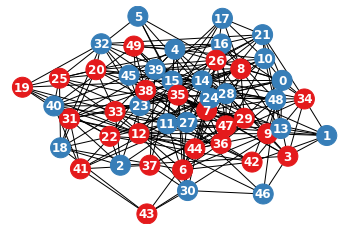

In [10]:
# plot result
colors = sample
get_colored_graph(G, pos, colors)

__DISCUSSION:__ This is a graph coloring problem. For every node we have to pick a color (blue or red). For this specific graph partitioning problem the goal is to find a coloring scheme with two subsets of the same size (50% of nodes are blue, the other 50% are red) with a minimal number of cut edges (a cut is an edge connecting two nodes of different color). 

---
## APPENDIX

In [11]:
# # Copyright 2019 D-Wave Systems, Inc.
# #
# # Licensed under the Apache License, Version 2.0 (the "License");
# # you may not use this file except in compliance with the License.
# # You may obtain a copy of the License at
# #
# #     http://www.apache.org/licenses/LICENSE-2.0
# #
# # Unless required by applicable law or agreed to in writing, software
# # distributed under the License is distributed on an "AS IS" BASIS,
# # WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# # See the License for the specific language governing permissions and
# # limitations under the License.

# # ------ Import necessary packages ----
# import networkx as nx 
# from collections import defaultdict
# from itertools import combinations
# from dwave.system.samplers import DWaveSampler
# from dwave.system.composites import EmbeddingComposite
# import math

# # ------- Set tunable parameters -------
# num_reads = 1000
# gamma = 80

# # ------- Set up our graph -------
# G = nx.gnp_random_graph(40, 0.2)

# print("Graph on {} nodes created with {} out of {} possible edges.".format(len(G.nodes), 
# len(G.edges), len(G.nodes) * (len(G.nodes)-1) / 2))

# # ------- Set up our QUBO dictionary -------

# # Initialize our Q matrix
# Q = defaultdict(int)

# # Fill in Q matrix
# for u, v in G.edges:
#     Q[(u,u)] += 1
#     Q[(v,v)] += 1
#     Q[(u,v)] += -2

# for i in G.nodes:
#     Q[(i,i)] += gamma*(1-len(G.nodes))

# for i, j in combinations(G.nodes, 2):
# 	Q[(i,j)] += 2*gamma

# # ------- Run our QUBO on the QPU -------

# # Set chain strength
# chain_strength = gamma*len(G.nodes)

# # Run the QUBO on the solver from your config file
# sampler = EmbeddingComposite(DWaveSampler(solver={'qpu': True}))
# response = sampler.sample_qubo(Q, chain_strength=chain_strength, num_reads=num_reads)

# # See if the best solution found is feasible, and if so print the number of cut edges.
# sample = response.record.sample[0]

# # In the case when n is odd, the set may have one more or one fewer nodes
# if sum(sample) in [math.floor(len(G.nodes)/2), math.ceil(len(G.nodes)/2)]:
#     num_cut_edges = 0
#     for u, v in G.edges:
#         num_cut_edges += sample[u] + sample[v] - 2*sample[u]*sample[v]
#     print("Valid partition found with", num_cut_edges, "cut edges.")
# else:
#     print("Invalid partition.")